# Imaging inverse problems with adversarial networks

This example shows you how to train various networks using adversarial training for deblurring problems. We demonstrate running training and inference using a conditional GAN (i.e DeblurGAN), CSGM, AmbientGAN and UAIR implemented in the `deepinv` library, and how to simply train your own GAN by using `deepinv.training.AdversarialTrainer`. These examples can also be easily extended to train more complicated GANs such as CycleGAN.

- Kupyn et al., [_DeblurGAN: Blind Motion Deblurring Using Conditional Adversarial Networks_](https://openaccess.thecvf.com/content_cvpr_2018/papers/Kupyn_DeblurGAN_Blind_Motion_CVPR_2018_paper.pdf)
- Bora et al., [_Compressed Sensing using Generative Models_](https://arxiv.org/abs/1703.03208) (CSGM)
- Bora et al., [_AmbientGAN: Generative models from lossy measurements_](https://openreview.net/forum?id=Hy7fDog0b)
- Pajot et al., [_Unsupervised Adversarial Image Reconstruction_](https://openreview.net/forum?id=BJg4Z3RqF7)

Adversarial networks are characterised by the addition of an adversarial loss $\mathcal{L}_\text{adv}$ to the standard reconstruction loss:

$$\mathcal{L}_\text{adv}(x,\hat x;D)=\mathbb{E}_{x\sim p_x}\left[q(D(x))\right]+\mathbb{E}_{\hat x\sim p_{\hat x}}\left[q(1-D(\hat x))\right]$$

where $D(\cdot)$ is the discriminator model, $x$ is the reference image, $\hat x$ is the estimated reconstruction, $q(\cdot)$ is a quality function (e.g $q(x)=x$ for WGAN). Training alternates between generator $f$ and discriminator $D$ in a minimax game. When there are no ground truths (i.e unsupervised), this may be defined on the measurements $y$ instead.

**Conditional GAN** forward pass: 

$$\hat x = f(y)$$

**Conditional GAN** loss: 

$$\mathcal{L}=\mathcal{L}_\text{sup}(\hat x, x)+\mathcal{L}_\text{adv}(\hat x, x;D)$$

where $\mathcal{L}_\text{sup}$ is a supervised loss such as pixel-wise MSE or VGG Perceptual Loss.

**CSGM**/**AmbientGAN** forward pass: 

$$\hat x = f(z),\quad z\sim \mathcal{N}(\mathbf{0},\mathbf{I}_k)$$

**CSGM** loss:

$$\mathcal{L}=\mathcal{L}_\text{adv}(\hat x, x;D)$$

**AmbientGAN** loss (where $A(\cdot)$ is the physics): 

$$\mathcal{L}=\mathcal{L}_\text{adv}(A(\hat x), y;D)$$

**CSGM**/**AmbientGAN** forward pass at eval time:

$$\hat x = f(\hat z)\quad\text{s.t.}\quad\hat z=\operatorname*{argmin}_z \lVert A(f(z))-y\rVert _2^2$$

**UAIR** forward pass:

$$\hat x = f(y)$$

**UAIR** loss: 

$$\mathcal{L}=\mathcal{L}_\text{adv}(\hat y, y;D)+\lVert A(f(\hat y))- \hat y\rVert^2_2,\quad\hat y=A(\hat x)$$

In [1]:
import deepinv as dinv
from deepinv.loss import adversarial
from deepinv.physics.generator import MotionBlurGenerator
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize
from torchvision.datasets.utils import download_and_extract_archive

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

Load data and apply some forward degradation to the images. For this example we use the Urban100 dataset resized to 128x128. We apply random motion blur physics using `deepinv.physics.generator.MotionBlurGenerator`.

In [2]:
physics = dinv.physics.Blur(padding="circular")
blur_generator = MotionBlurGenerator((11, 11))

In [63]:
download_and_extract_archive(
    "https://huggingface.co/datasets/eugenesiow/Urban100/resolve/main/data/Urban100_HR.tar.gz?download=true",
    "Urban100",
    filename="Urban100_HR.tar.gz",
    md5="65d9d84a34b72c6f7ca1e26a12df1e4c"
)

Using downloaded and verified file: Urban100\Urban100_HR.tar.gz
Extracting Urban100\Urban100_HR.tar.gz to Urban100


In [3]:
train_dataset, test_dataset = random_split(
    ImageFolder("Urban100", transform=Compose([ToTensor(), Resize(256), CenterCrop(128)])),
    (0.8, 0.2)
    )
    
train_dataloader = DataLoader(train_dataset, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=False)

Define reconstruction network (i.e conditional generator) and discriminator network to use for adversarial training. For demonstration we use a simple U-Net as the reconstruction network and the discriminator from [PatchGAN](https://arxiv.org/abs/1611.07004), but these can be replaced with any architecture e.g transformers, unrolled etc. Further discriminator models are in `deepinv.models.gan`.

In [4]:
def get_models(model=None, D=None, lr_g=1e-4, lr_d=1e-4):
    if model is None:
        model = dinv.models.UNet(
            in_channels=3, 
            out_channels=3,
            scales=2,
            circular_padding=True,
            batch_norm=False
            )

    if D is None:
        D = dinv.models.PatchGANDiscriminator(
            n_layers=2,
            batch_norm=False
        )

    optimizer = dinv.training.adversarial.AdversarialOptimizer(
        torch.optim.Adam(model.parameters(), lr=lr_g, weight_decay=1e-8),
        torch.optim.Adam(D.parameters(),     lr=lr_d, weight_decay=1e-8),
    )
    scheduler = dinv.training.adversarial.AdversarialScheduler(
        torch.optim.lr_scheduler.StepLR(optimizer.G, step_size=5, gamma=0.9),
        torch.optim.lr_scheduler.StepLR(optimizer.D, step_size=5, gamma=0.9)
    )
    
    return model, D, optimizer, scheduler

### Conditional GAN training

In [73]:
model, D, optimizer, scheduler = get_models()

Construct pixel-wise and adversarial losses as defined above. We use the MSE for the supervised pixel-wise metric for simplicity but this can be easily replaced with a perceptual loss if desired.

In [74]:
loss_g = [
    dinv.loss.SupLoss(metric=torch.nn.MSELoss()),
    adversarial.SupAdversarialGeneratorLoss(device=device)
]
loss_d = adversarial.SupAdversarialDiscriminatorLoss(device=device)

Train the networks using `AdversarialTrainer`. We only train for 3 epochs for speed, but below we also show results with a pretrained model trained in the exact same way after 50 epochs.

In [92]:
model = dinv.training.AdversarialTrainer(
    model=model,
    D=D,
    physics=physics,
    physics_generator=blur_generator,
    online_measurements=True,
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    epochs=3,
    losses=loss_g,
    losses_d=loss_d,
    optimizer=optimizer,
    scheduler=scheduler,
    verbose=True,
    show_progress_bar=False,
    save_path=None,
    device=device
).train()

The model has 444867 trainable parameters
Eval epoch 0: PSNR=26.434
Train epoch 0: SupLoss=0.004, SupAdversarialGeneratorLoss=0.003, TotalLoss=0.007, PSNR=25.602
Eval epoch 1: PSNR=25.709
Train epoch 1: SupLoss=0.004, SupAdversarialGeneratorLoss=0.003, TotalLoss=0.007, PSNR=25.41
Eval epoch 2: PSNR=25.545
Train epoch 2: SupLoss=0.004, SupAdversarialGeneratorLoss=0.003, TotalLoss=0.007, PSNR=25.546
Eval epoch 3: PSNR=25.571
Train epoch 3: SupLoss=0.004, SupAdversarialGeneratorLoss=0.003, TotalLoss=0.007, PSNR=25.534
Eval epoch 4: PSNR=25.509
Train epoch 4: SupLoss=0.004, SupAdversarialGeneratorLoss=0.003, TotalLoss=0.007, PSNR=25.513
Eval epoch 5: PSNR=25.542
Train epoch 5: SupLoss=0.004, SupAdversarialGeneratorLoss=0.003, TotalLoss=0.007, PSNR=25.523
Eval epoch 6: PSNR=25.556
Train epoch 6: SupLoss=0.004, SupAdversarialGeneratorLoss=0.003, TotalLoss=0.007, PSNR=25.569
Eval epoch 7: PSNR=25.558
Train epoch 7: SupLoss=0.004, SupAdversarialGeneratorLoss=0.003, TotalLoss=0.007, PSNR=25.502

Show pretrained model results:

In [96]:
ckpt = torch.hub.load_state_dict_from_url(
    dinv.models.utils.get_weights_url("deblurgan-demo", "model.pth"),
    map_location=lambda s, _: s,
    file_name="model.pth",
)

Downloading: "https://huggingface.co/deepinv/deblurgan-demo/resolve/main/model.pth?download=true" to C:\Users\s2558406/.cache\torch\hub\checkpoints\model.pth
100%|██████████| 1.70M/1.70M [00:00<00:00, 6.65MB/s]


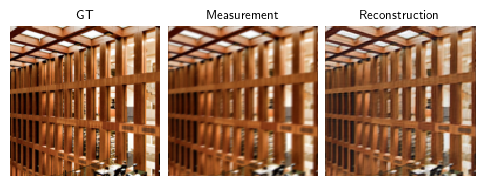

In [98]:
model.load_state_dict(ckpt["state_dict"])

x, _ = next(iter(test_dataloader))
y = physics(x, **blur_generator.step())
dinv.utils.plot([x, y, model(y)], titles=["GT", "Measurement", "Reconstruction"])

### UAIR training

In [9]:
model, D, optimizer, scheduler = get_models(lr_g=1e-4, lr_d=4e-4) # learning rates from original paper

Construct losses as defined above

In [10]:
loss_g = adversarial.UAIRGeneratorLoss(device=device)
loss_d = adversarial.UAIRDiscriminatorLoss(device=device)

Train the networks using `AdversarialTrainer`

In [11]:
model = dinv.training.AdversarialTrainer(
    model=model,
    D=D,
    physics=physics,
    physics_generator=blur_generator,
    online_measurements=True,
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    epochs=3,
    losses=loss_g,
    losses_d=loss_d,
    optimizer=optimizer,
    scheduler=scheduler,
    verbose=True,
    show_progress_bar=False,
    save_path=None,
    device=device
).train()

The model has 444867 trainable parameters
Eval epoch 0: PSNR=15.046
Train epoch 0: TotalLoss=0.221, PSNR=15.249
Eval epoch 1: PSNR=15.329
Train epoch 1: TotalLoss=0.218, PSNR=15.63
Eval epoch 2: PSNR=15.692
Train epoch 2: TotalLoss=0.221, PSNR=15.833


### CSGM / AmbientGAN training

In [5]:
model = dinv.models.CSGMGenerator(dinv.models.DCGANGenerator(output_size=128, nz=100, ngf=32), inf_tol=1e-2)
D = dinv.models.DCGANDiscriminator(ndf=32)
_, _, optimizer, scheduler = get_models(model=model, D=D, lr_g=2e-4, lr_d=2e-4) # learning rates from original paper

Construct losses as defined above. We are free to choose between supervised and unsupervised adversarial losses, where supervised gives CSGM and unsupervised gives AmbientGAN.

In [6]:
loss_g = adversarial.SupAdversarialGeneratorLoss(device=device)
loss_d = adversarial.SupAdversarialDiscriminatorLoss(device=device)

Train the networks using `AdversarialTrainer`. Since inference is very slow for CSGM/AmbientGAN as it requires an optimisation, we only do one evaluation at the end. Note the train PSNR is meaningless as this generative model is trained on random latents.

In [7]:
trainer = dinv.training.AdversarialTrainer(
    model=model,
    D=D,
    physics=physics,
    physics_generator=blur_generator,
    online_measurements=True,
    train_dataloader=train_dataloader,
    epochs=3,
    losses=loss_g,
    losses_d=loss_d,
    optimizer=optimizer,
    scheduler=scheduler,
    verbose=True,
    show_progress_bar=False,
    save_path=None,
    device=device
)
model = trainer.train()

The model has 3608000 trainable parameters
Train epoch 0: TotalLoss=0.005, PSNR=4.026
Train epoch 1: TotalLoss=0.006, PSNR=4.855
Train epoch 2: TotalLoss=0.006, PSNR=5.416


Run evaluation of generative model by running test-time optimisation using test measurements. Note that we do not get great results as CSGM / AmbientGAN relies on large datasets of diverse samples, and we run the optimisation to a relatively high tolerance for speed.

In [8]:
psnr = trainer.test(test_dataloader)[0]
print("Test PSNR", psnr)

Test PSNR: No learning rec.: 24.380+-2.300 | Model: 6.673+-1.264. 
Test PSNR 6.672804999351501
